# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.46KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

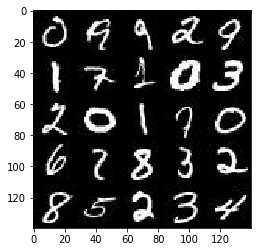

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

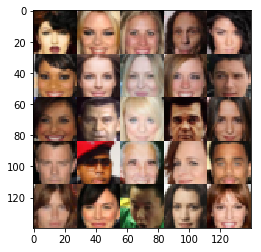

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28 * 28 * 3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        # 14 * 14 * 64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 128
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 * 4 * 256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer1 = tf.layers.dense(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7 * 7 * 512
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14 * 14 * 256
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28 * 28 * 128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 0.0001... Generator Loss: 13.1957...
Epoch 0/2... Discriminator Loss: 1.1509... Generator Loss: 0.3822...
Epoch 0/2... Discriminator Loss: 0.0007... Generator Loss: 7.3410...
Epoch 0/2... Discriminator Loss: 0.0242... Generator Loss: 5.1619...
Epoch 0/2... Discriminator Loss: 0.0060... Generator Loss: 10.7454...
Epoch 0/2... Discriminator Loss: 0.0925... Generator Loss: 7.7246...
Epoch 0/2... Discriminator Loss: 1.0291... Generator Loss: 4.0233...
Epoch 0/2... Discriminator Loss: 0.3926... Generator Loss: 2.7824...
Epoch 0/2... Discriminator Loss: 1.0191... Generator Loss: 1.1537...
Epoch 0/2... Discriminator Loss: 0.8374... Generator Loss: 1.2124...


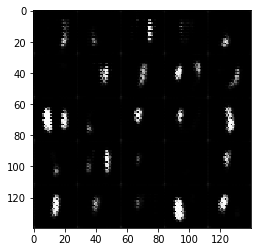

Epoch 0/2... Discriminator Loss: 1.1452... Generator Loss: 0.6338...
Epoch 0/2... Discriminator Loss: 1.3014... Generator Loss: 0.5159...
Epoch 0/2... Discriminator Loss: 1.5433... Generator Loss: 0.3368...
Epoch 0/2... Discriminator Loss: 0.4523... Generator Loss: 1.9995...
Epoch 0/2... Discriminator Loss: 0.6141... Generator Loss: 1.1399...
Epoch 0/2... Discriminator Loss: 0.3637... Generator Loss: 1.8613...
Epoch 0/2... Discriminator Loss: 0.4758... Generator Loss: 1.4107...
Epoch 0/2... Discriminator Loss: 0.5494... Generator Loss: 1.6479...
Epoch 0/2... Discriminator Loss: 0.3594... Generator Loss: 1.9552...
Epoch 0/2... Discriminator Loss: 0.2458... Generator Loss: 2.4886...


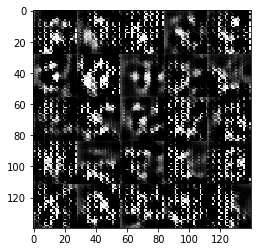

Epoch 0/2... Discriminator Loss: 0.6648... Generator Loss: 1.1451...
Epoch 0/2... Discriminator Loss: 0.1905... Generator Loss: 2.4149...
Epoch 0/2... Discriminator Loss: 0.1804... Generator Loss: 3.1247...
Epoch 0/2... Discriminator Loss: 0.2887... Generator Loss: 3.9351...
Epoch 0/2... Discriminator Loss: 0.5335... Generator Loss: 2.7599...
Epoch 0/2... Discriminator Loss: 0.6898... Generator Loss: 1.1537...
Epoch 0/2... Discriminator Loss: 0.5646... Generator Loss: 1.2076...
Epoch 0/2... Discriminator Loss: 0.3052... Generator Loss: 3.6856...
Epoch 0/2... Discriminator Loss: 0.5172... Generator Loss: 1.4250...
Epoch 0/2... Discriminator Loss: 0.3286... Generator Loss: 4.0707...


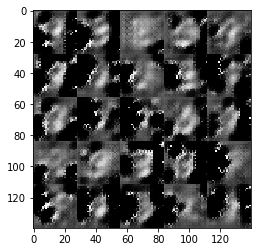

Epoch 0/2... Discriminator Loss: 2.5978... Generator Loss: 0.1281...
Epoch 0/2... Discriminator Loss: 0.5394... Generator Loss: 3.2020...
Epoch 0/2... Discriminator Loss: 0.2093... Generator Loss: 2.5939...
Epoch 0/2... Discriminator Loss: 0.4066... Generator Loss: 2.6912...
Epoch 0/2... Discriminator Loss: 1.1095... Generator Loss: 0.6694...
Epoch 0/2... Discriminator Loss: 0.4026... Generator Loss: 1.9961...
Epoch 0/2... Discriminator Loss: 0.3933... Generator Loss: 3.5747...
Epoch 0/2... Discriminator Loss: 0.8011... Generator Loss: 0.8954...
Epoch 0/2... Discriminator Loss: 0.7859... Generator Loss: 1.0179...
Epoch 0/2... Discriminator Loss: 0.2461... Generator Loss: 2.6189...


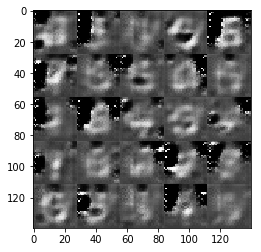

Epoch 0/2... Discriminator Loss: 0.9845... Generator Loss: 1.9636...
Epoch 0/2... Discriminator Loss: 0.4700... Generator Loss: 1.5359...
Epoch 0/2... Discriminator Loss: 0.3769... Generator Loss: 2.8344...
Epoch 0/2... Discriminator Loss: 1.0996... Generator Loss: 3.2428...
Epoch 0/2... Discriminator Loss: 0.9846... Generator Loss: 1.0027...
Epoch 0/2... Discriminator Loss: 0.6603... Generator Loss: 1.3702...
Epoch 1/2... Discriminator Loss: 0.4629... Generator Loss: 3.0671...
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.5765...
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 1.9497...
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.4603...


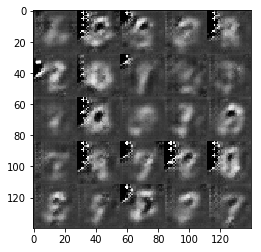

Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 1.7519...
Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 2.0151...
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 2.1837...
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 0.9043...
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.7193...
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.1602...
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 2.4106...
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.9008...
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 0.8074...
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 1.2495...


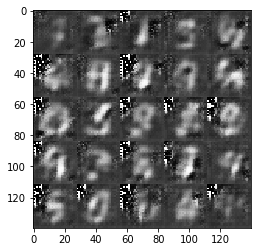

Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 1.4590...
Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 1.8052...
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.6803...
Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 2.0172...
Epoch 1/2... Discriminator Loss: 0.5499... Generator Loss: 1.4776...
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.7574...
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.3858...
Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.7545...
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 0.9190...
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 1.8365...


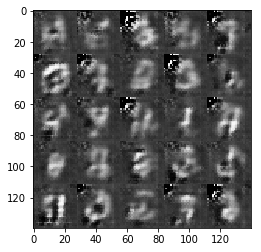

Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.1614...
Epoch 1/2... Discriminator Loss: 0.4803... Generator Loss: 3.2651...
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 1.7567...
Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 1.9111...
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 2.1936...
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 1.8077...
Epoch 1/2... Discriminator Loss: 0.3128... Generator Loss: 2.6946...
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 2.4544...
Epoch 1/2... Discriminator Loss: 0.2836... Generator Loss: 2.7827...
Epoch 1/2... Discriminator Loss: 0.6350... Generator Loss: 1.2123...


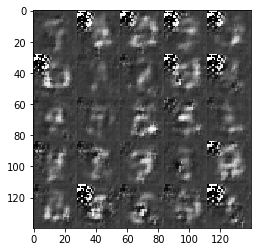

Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.6638...
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 2.1066...
Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 3.3095...
Epoch 1/2... Discriminator Loss: 0.5120... Generator Loss: 2.2459...
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 1.8145...
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.1859...
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.3451...
Epoch 1/2... Discriminator Loss: 0.4766... Generator Loss: 1.8024...


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 0.0003... Generator Loss: 10.2430...
Epoch 0/1... Discriminator Loss: 0.0155... Generator Loss: 7.8015...
Epoch 0/1... Discriminator Loss: 0.4090... Generator Loss: 2.1123...
Epoch 0/1... Discriminator Loss: 0.0928... Generator Loss: 3.4300...
Epoch 0/1... Discriminator Loss: 0.4030... Generator Loss: 2.0937...
Epoch 0/1... Discriminator Loss: 0.0490... Generator Loss: 4.6480...
Epoch 0/1... Discriminator Loss: 0.4728... Generator Loss: 2.6378...
Epoch 0/1... Discriminator Loss: 0.2951... Generator Loss: 4.8351...
Epoch 0/1... Discriminator Loss: 2.7803... Generator Loss: 0.7635...
Epoch 0/1... Discriminator Loss: 1.1863... Generator Loss: 0.6359...


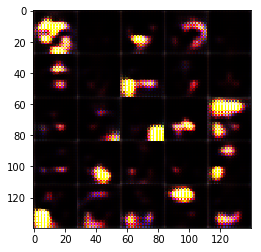

Epoch 0/1... Discriminator Loss: 0.2773... Generator Loss: 2.4075...
Epoch 0/1... Discriminator Loss: 0.1026... Generator Loss: 3.4970...
Epoch 0/1... Discriminator Loss: 0.1782... Generator Loss: 2.6909...
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.7071...
Epoch 0/1... Discriminator Loss: 0.4210... Generator Loss: 1.6618...
Epoch 0/1... Discriminator Loss: 0.2895... Generator Loss: 1.7997...
Epoch 0/1... Discriminator Loss: 0.1324... Generator Loss: 2.8257...
Epoch 0/1... Discriminator Loss: 0.6056... Generator Loss: 1.4828...
Epoch 0/1... Discriminator Loss: 0.1361... Generator Loss: 2.7254...
Epoch 0/1... Discriminator Loss: 0.2595... Generator Loss: 14.2815...


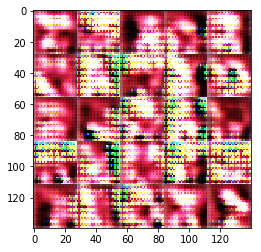

Epoch 0/1... Discriminator Loss: 0.3345... Generator Loss: 3.7468...
Epoch 0/1... Discriminator Loss: 0.3026... Generator Loss: 2.2470...
Epoch 0/1... Discriminator Loss: 0.7574... Generator Loss: 1.1420...
Epoch 0/1... Discriminator Loss: 0.2861... Generator Loss: 2.2670...
Epoch 0/1... Discriminator Loss: 0.2371... Generator Loss: 2.2522...
Epoch 0/1... Discriminator Loss: 0.0434... Generator Loss: 4.8913...
Epoch 0/1... Discriminator Loss: 0.0178... Generator Loss: 8.2494...
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 6.2453...
Epoch 0/1... Discriminator Loss: 1.1737... Generator Loss: 0.6342...
Epoch 0/1... Discriminator Loss: 0.0437... Generator Loss: 4.1416...


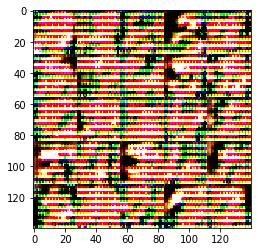

Epoch 0/1... Discriminator Loss: 0.0200... Generator Loss: 5.9713...
Epoch 0/1... Discriminator Loss: 0.0203... Generator Loss: 5.1340...
Epoch 0/1... Discriminator Loss: 0.0428... Generator Loss: 3.8852...
Epoch 0/1... Discriminator Loss: 0.0677... Generator Loss: 3.4070...
Epoch 0/1... Discriminator Loss: 0.0071... Generator Loss: 6.5168...
Epoch 0/1... Discriminator Loss: 0.0139... Generator Loss: 5.8685...
Epoch 0/1... Discriminator Loss: 0.0571... Generator Loss: 5.6748...
Epoch 0/1... Discriminator Loss: 0.0364... Generator Loss: 4.7817...
Epoch 0/1... Discriminator Loss: 0.0640... Generator Loss: 3.6308...
Epoch 0/1... Discriminator Loss: 0.0193... Generator Loss: 4.8242...


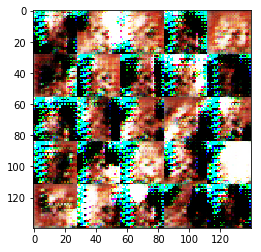

Epoch 0/1... Discriminator Loss: 1.2366... Generator Loss: 2.4044...
Epoch 0/1... Discriminator Loss: 0.9233... Generator Loss: 4.9485...
Epoch 0/1... Discriminator Loss: 1.1945... Generator Loss: 0.7702...
Epoch 0/1... Discriminator Loss: 1.5387... Generator Loss: 0.4849...
Epoch 0/1... Discriminator Loss: 0.1535... Generator Loss: 2.7716...
Epoch 0/1... Discriminator Loss: 0.1453... Generator Loss: 3.2610...
Epoch 0/1... Discriminator Loss: 0.2899... Generator Loss: 2.8191...
Epoch 0/1... Discriminator Loss: 0.1278... Generator Loss: 4.1732...
Epoch 0/1... Discriminator Loss: 0.0943... Generator Loss: 5.4488...
Epoch 0/1... Discriminator Loss: 1.0037... Generator Loss: 9.7937...


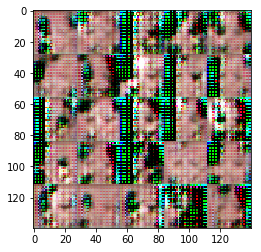

Epoch 0/1... Discriminator Loss: 0.1674... Generator Loss: 4.5970...
Epoch 0/1... Discriminator Loss: 0.1653... Generator Loss: 2.9906...
Epoch 0/1... Discriminator Loss: 0.2989... Generator Loss: 1.9788...
Epoch 0/1... Discriminator Loss: 0.3414... Generator Loss: 2.1710...
Epoch 0/1... Discriminator Loss: 0.1198... Generator Loss: 5.3539...
Epoch 0/1... Discriminator Loss: 0.2947... Generator Loss: 3.9691...
Epoch 0/1... Discriminator Loss: 0.3117... Generator Loss: 2.7724...
Epoch 0/1... Discriminator Loss: 0.1854... Generator Loss: 3.1953...
Epoch 0/1... Discriminator Loss: 1.1114... Generator Loss: 6.7122...
Epoch 0/1... Discriminator Loss: 0.2284... Generator Loss: 2.4636...


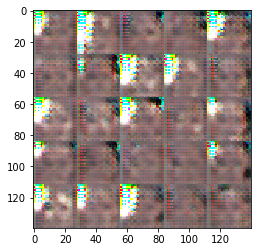

Epoch 0/1... Discriminator Loss: 0.0875... Generator Loss: 3.3935...
Epoch 0/1... Discriminator Loss: 0.1892... Generator Loss: 3.4243...
Epoch 0/1... Discriminator Loss: 0.0402... Generator Loss: 5.1516...
Epoch 0/1... Discriminator Loss: 0.5245... Generator Loss: 1.4664...
Epoch 0/1... Discriminator Loss: 0.3606... Generator Loss: 3.5619...
Epoch 0/1... Discriminator Loss: 1.3279... Generator Loss: 4.4765...
Epoch 0/1... Discriminator Loss: 0.5721... Generator Loss: 1.7664...
Epoch 0/1... Discriminator Loss: 0.5152... Generator Loss: 3.3849...
Epoch 0/1... Discriminator Loss: 1.0464... Generator Loss: 2.0476...
Epoch 0/1... Discriminator Loss: 0.4966... Generator Loss: 2.3745...


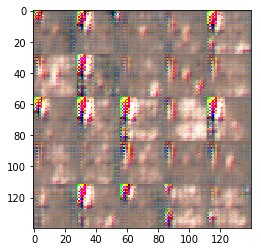

Epoch 0/1... Discriminator Loss: 0.4040... Generator Loss: 2.8760...
Epoch 0/1... Discriminator Loss: 0.3878... Generator Loss: 2.6753...
Epoch 0/1... Discriminator Loss: 1.8763... Generator Loss: 6.4165...
Epoch 0/1... Discriminator Loss: 1.1396... Generator Loss: 5.0195...
Epoch 0/1... Discriminator Loss: 0.7809... Generator Loss: 1.2798...
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 2.6965...
Epoch 0/1... Discriminator Loss: 0.4711... Generator Loss: 2.2848...
Epoch 0/1... Discriminator Loss: 0.3045... Generator Loss: 2.7382...
Epoch 0/1... Discriminator Loss: 1.1126... Generator Loss: 1.9040...
Epoch 0/1... Discriminator Loss: 0.6430... Generator Loss: 1.1073...


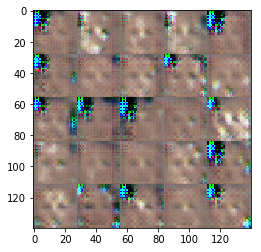

Epoch 0/1... Discriminator Loss: 0.3183... Generator Loss: 2.7414...
Epoch 0/1... Discriminator Loss: 4.1639... Generator Loss: 6.2811...
Epoch 0/1... Discriminator Loss: 0.7839... Generator Loss: 1.0008...
Epoch 0/1... Discriminator Loss: 1.0178... Generator Loss: 0.6188...
Epoch 0/1... Discriminator Loss: 0.5177... Generator Loss: 1.7731...
Epoch 0/1... Discriminator Loss: 0.6602... Generator Loss: 1.5532...


In [37]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。